In [34]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange
from tqdm.keras import TqdmCallback

import os
import math

The training data should be prepared as described by Dong et al. in [Image Super-Resolution Using Deep Convolutional Networks](https://arxiv.org/pdf/1501.00092.pdf):

> In the training phase, the ground truth images $X_i$ are prepared as $f_{sub}\times f_{sub}\times c$-pixel sub-images randomly cropped from the training images. By “sub-images” we mean these samples are treated as small “images” ratherthan “patches”, in the sense that “patches” are overlapping and require some averaging as post-processing but “sub-images” need not. To synthesize the low-resolution samples $Y_i$, we blur a sub-image by a Gaussian kernel, sub-sample it by the upscaling factor, and upscale it by the same factor via bicubic interpolation.

The paper we're attempting to replicate did not train their model on color images, so we will convert the data set to greyscale before cropping.

In [35]:
# Dataset parameters
IMAGE_DIR = r'./SR_training_datasets/T91/'
SUBIMAGE_SIZE = [33, 33, 1]
SUBIMAGE_QUANTITY = 289
GAUSSIAN_SHAPE = [3, 3]
GAUSSIAN_SIGMA = 1.0
SCALING_FACTOR = 2

BATCH_SIZE = 128

In [36]:
image_paths = [os.path.join(IMAGE_DIR, path) for path in os.listdir(IMAGE_DIR)]

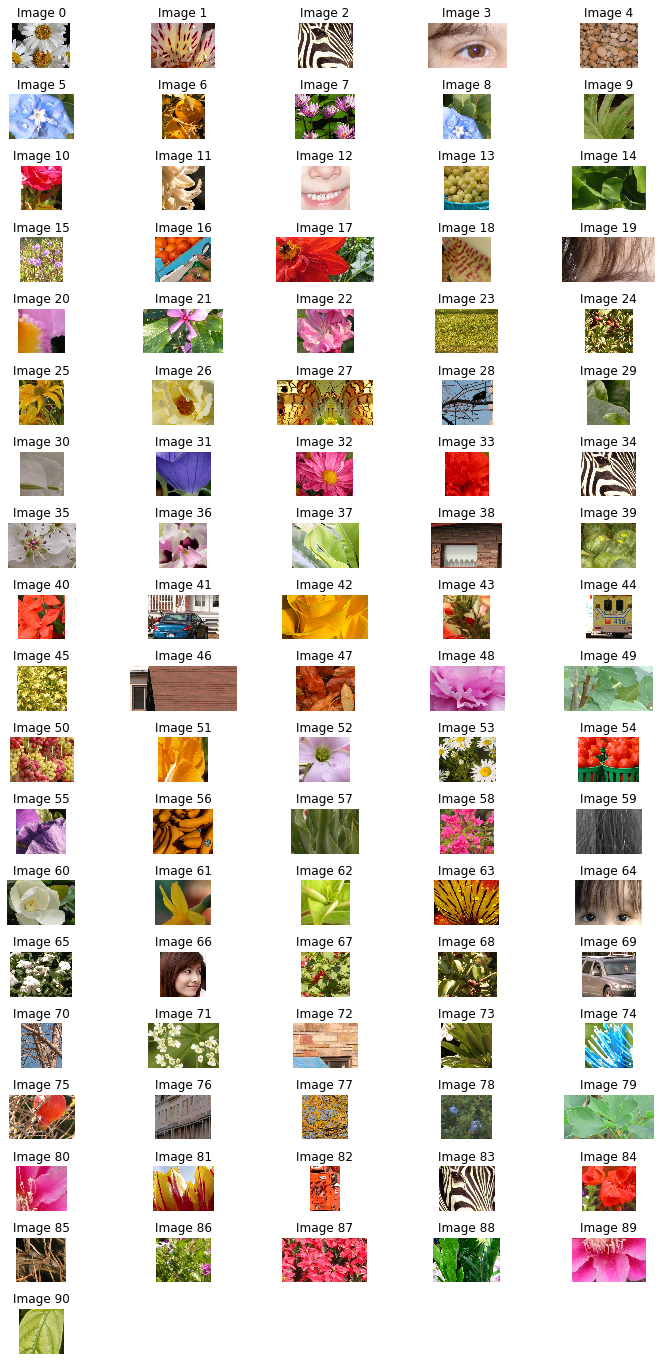

In [37]:
plt.figure(figsize=(10, 20))
for i, path in enumerate(image_paths):
    image = plt.imread(path)
    plt.subplot(20, 5, i + 1)
    plt.title('Image %d' % i)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image)
plt.show()

In [38]:
# Create high-res subimages
def gen_subimg(path):
    in_image = tf.image.decode_png(tf.io.read_file(path))
 
    # Convert to grayscale and normalize to [0, 1.0]

    image = tf.image.rgb_to_grayscale(in_image)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
 
    return [tf.image.random_crop(image, SUBIMAGE_SIZE, seed=i) for i in range(SUBIMAGE_QUANTITY)]

In [39]:
subimgs = list(map(gen_subimg, image_paths))

In [40]:
def plot_subimgs(images):
    subplot_dim = math.ceil(math.sqrt(len(images)))
 
    plt.figure(figsize=(10, 2.5))
    for index,subimg in enumerate(images):
        plt.subplot(math.ceil(subplot_dim / 2), subplot_dim * 2, index + 1)
        plt.axis('off')
        plt.imshow(np.asarray(subimg[:, :, 0], dtype='float'), cmap='Greys_r')
    plt.show()

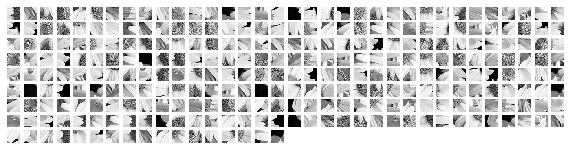

In [41]:
# Plot all subimages
# list(map(plot_subimgs, subimgs));

# Plot subimages for one image
plot_subimgs(subimgs[0])

In [42]:
def downsample_subimgs(images):
    result = []
    for subimg in images:
        highres = subimg
        blurry = tfa.image.gaussian_filter2d(subimg, GAUSSIAN_SHAPE, GAUSSIAN_SIGMA)
        downsampled = tf.image.resize(blurry, np.divide(SUBIMAGE_SIZE[0:2], SCALING_FACTOR))
        final = tf.image.resize(downsampled, SUBIMAGE_SIZE[0:2], method='bicubic')
        result.append(final)
    return result
  

In [43]:
lr_subimgs = list(map(downsample_subimgs, subimgs))

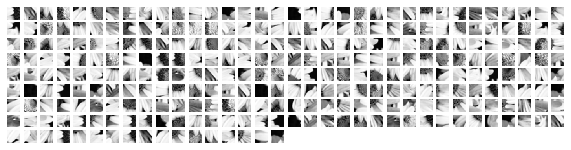

In [44]:
# Plot all subimages
# list(map(plot_subimgs, subimgs));

# Plot subimages for one image
plot_subimgs(lr_subimgs[0])

In [45]:
# Crop subimages to be the same size as the output layer
subimgs = [tf.image.crop_to_bounding_box(subimg, 6, 6, 21, 21) for subimg in subimgs]

In [46]:
# Combine the original high-res subimages with the low-res derivatives to complete the dataset
dataset = tf.data.Dataset.from_tensor_slices(((lr_subimgs, subimgs)))

# "Image Super-Resolution Using Deep Convolutional Networks" Model

In [62]:
# Model parameters
n_1 = 64
n_2 = 32

f_1 = 9 # Filter 1 size
f_2 = 1 # Filter 2 size
f_3 = 5 # Filter 3 size

c = SUBIMAGE_SIZE[2] # Number of color channels

>#### 3.1.1 Patch extraction and representation
>
>A popular strategy in image restoration (e.g.,[1]) is to densely extract patches and then represent them by a set of pre-trained bases such as PCA, DCT, Haar, etc. This is equivalent to convolving the image by a set of filters, each of which is a basis. In our formulation, we involve the optimization of these bases into the optimization of the network. Formally, our first layer is expressed as an operation $F_1$:
>
>$$
F_1(\vec Y) = \max(0,W_1∗\vec Y+B_1)
$$
>
>where $W_1$ and $B_1$ represent the filters and biases respectively, and ’$∗$’ denotes the convolution operation. Here, $W_1$ corresponds to $n_1$ filters of support $c\times f_1\times f_1$, where $c$ is the number of channels in the input image, $f_1$ is the spatial size of a filter. Intuitively, $W_1$ applies $n_1$ convolutions on the image, and each convolution has a kernel size $c×f1×f1$. The output is composed of $n_1$ feature maps. $B_1$ is an $n_1$-dimensional vector, whose each element is associated with a filter. We apply the Rectified Linear Unit (ReLU, $\max(0,x)$) [33] on the filter responses.

In [63]:
# F_1
F1 = layers.Conv2D(n_1, f_1, activation='relu', use_bias=True, input_shape=SUBIMAGE_SIZE)

>#### 3.1.2 Non-linear mapping
>The first layer extracts an $n_1$-dimensional feature for each patch. In the second operation, we map each of these $n_1$-dimensional vectors into an $n_2$-dimensional one. This is equivalent to applying $n_2$ filters which have a trivial spatial support $1\times1$. This interpretation is only valid for $1\times1$ filters. But it is easy to generalize to larger filters like $3\times3$ or $5\times5$. In that case, the non-linear mapping is not on a patch of the input image; instead, it is on a $3\times3$ or $5\times5$ “patch” of the feature map. The operation of the second layer is:
>
>$$
F_2(\vec Y) = \max(0,W_2∗F_1(\vec Y) +B_2)
$$
>
>Here $W_2$ contains $n_2$ filters of size $n_1\times f_2\times f_2$, and B_2 is $n_2$-dimensional. Each of the output $n_2$-dimensional vectors is conceptually a representation of a high-resolution patch that will be used for reconstruction. It is possible to add more convolutional layers to increase the non-linearity. But this can increase the complexity of the model ($n_2\times f_2\times f_2\times n_2$ parameters for one layer), and thus demands more training time. We will explore deeper structures by introducing additional non-linear mapping layers in Section 4.3.3.

In [64]:
# F_2
F2 = layers.Conv2D(n_2, f_2, activation='relu', use_bias=True)

>#### 3.1.3 Reconstruction
>In the traditional methods, the predicted overlapping high-resolution patches are often averaged to produce the final full image. The averaging can be considered as a pre-defined filter on a set of feature maps (where each position is the “flattened” vector form of a high-resolution patch). Motivated by this, we define a convolutional layer to produce the final high-resolution image:
>
>$$
F(\vec Y) = W_3∗F_2(\vec Y) +B_3
$$
>
>Here $W_3$ corresponds to $c$ filters of a size $n_2\times f_3\times f_3$, and $B_3$ is a $c$-dimensional vector. If the representations of the high-resolution patches are in the image domain (i.e., we can simply reshape each representation to form the patch), we expect that the filters act like an averaging filter; if the representations of the high-resolution patches are in some other domains (e.g., coefficients in terms of some bases), we expect that $W_3$ behaves like first projecting the coefficients onto the image domain and then averaging. In either way, $W_3$ is a set of linear filters.

In [65]:
# F_3
F3 = layers.Conv2D(n_2, f_3, use_bias=True)

In [66]:
def central_loss(y_true, y_pred):
    #resize true and pred to be 
    print(y_true.shape, y_pred.shape)
    y_true_resize = tf.slice(y_true, [0, y_true.shape[1] // 2, y_true.shape[2] // 2, 0], [y_true.shape[0], 1, 1, y_true.shape[3]])
    y_pred_resize = tf.slice(y_pred, [0, y_pred.shape[1] // 2, y_pred.shape[2] // 2, 0], [y_pred.shape[0], 1, 1, y_pred.shape[3]])
    print(y_true_resize.shape, y_pred_resize.shape)
    
    return tf.keras.losses.MSE(y_true_resize, y_pred_resize)

In [67]:
strategy = tf.distribute.MirroredStrategy(['/gpu:0', '/gpu:1'])
history = None
with strategy.scope():
    model = models.Sequential(name='Greyscale_RELU')
    model.add(F1)
    model.add(F2)
    model.add(F3)
    
    model.summary()
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
    history = model.fit(dataset, epochs=100, verbose=0, callbacks=[TqdmCallback(verbose=1)])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model: "Greyscale_RELU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 25, 25, 64)        5248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 32)        2080      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 32)        25632     
Total params: 32,960
Trainable params: 32,960
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


KeyboardInterrupt: 

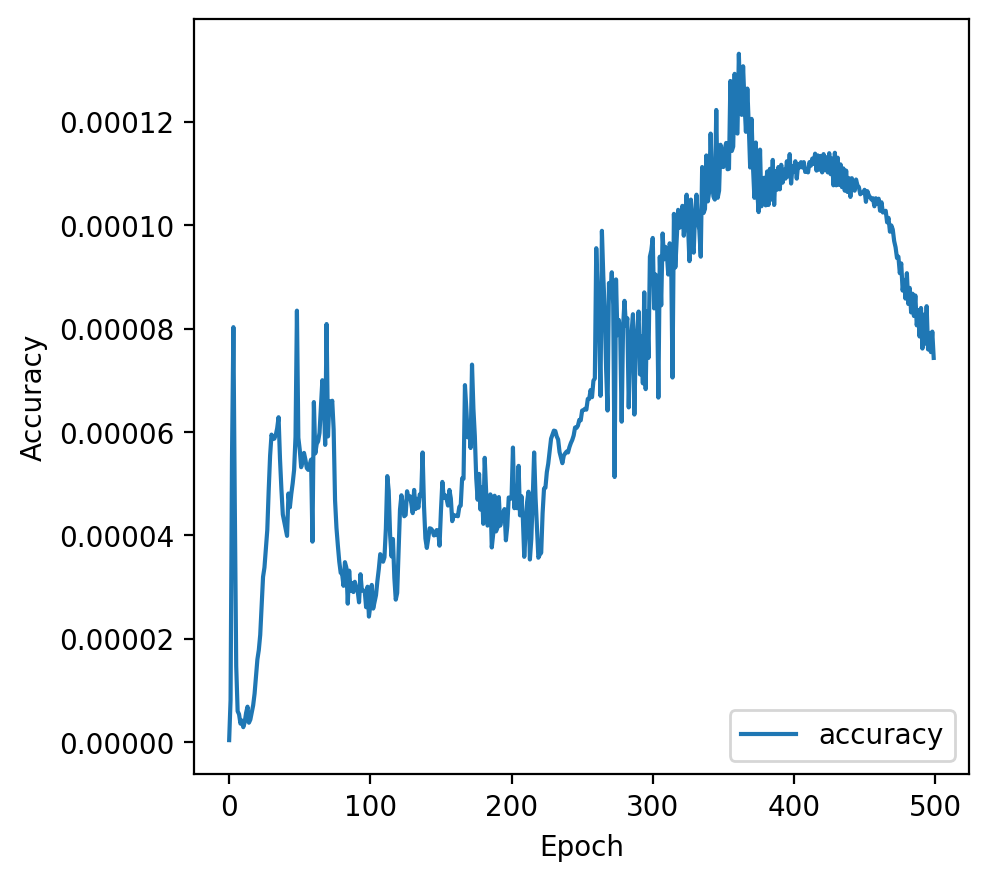

In [60]:
plt.figure(figsize=(5, 5), dpi=200)
plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot( 20 * math.log(1, 10) - 10 * math.log(history.history['error']) history.history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()